In [ ]:
#@title Install necessary libraries
!pip install -q diffusers transformers accelerate controlnet_aux datasets
!pip install -q opencv-python

print("Dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 15.9 MB/s eta 0:00:00
Dependencies installed successfully!


In [ ]:
from datasets import load_dataset
import os

# 1. Define path names
local_base_path = "/content/Controlnet_Sketch"
images_path = os.path.join(local_base_path, "original")
conditions_path = os.path.join(local_base_path, "conditioning")

# 2. Create the folders on the disk
os.makedirs(images_path, exist_ok=True)
os.makedirs(conditions_path, exist_ok=True)
print(f"Folders created at: {local_base_path}")
# ---------------------------------

# 3. Load the dataset
dataset = load_dataset("lambdalabs/naruto-blip-captions", split="train")

print(f"Loaded {len(dataset)} images.")
print(f"Column names: {dataset.column_names}")

Folders created at: /content/Controlnet_Sketch


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

data/train-00000-of-00002-12944970063701(…):   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00001-of-00002-cefa2f480689f1(…):   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Loaded 1221 images.
Column names: ['image', 'text']


In [ ]:
from controlnet_aux import LineartAnimeDetector
import torch

# Initialize the detector
detector = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
detector = detector.to(device)

print(f"Detector loaded on {device}.")

/usr/local/lib/python3.12/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segmen

netG.pth:   0%|          | 0.00/218M [00:00<?, ?B/s]

Detector loaded on cuda.


In [ ]:
import json
from tqdm import tqdm
import cv2
import numpy as np

metadata_lines = []

print("Processing images locally...")

for idx, item in enumerate(tqdm(dataset)):
    # 1. Resize
    original_image = item['image'].convert("RGB").resize((512, 512))

    # 2. Generate Sketch
    conditioning_image = detector(original_image, detect_resolution=512, image_resolution=512)

    # 3. Define filenames
    img_filename = f"image_{idx:04d}.png"
    cond_filename = f"condition_{idx:04d}.png"

    # 4. Save to LOCAL folders
    original_save_path = os.path.join(images_path, img_filename)
    cond_save_path = os.path.join(conditions_path, cond_filename)

    original_image.save(original_save_path)
    conditioning_image.save(cond_save_path)

    # 5. Metadata Entry
    entry = {
        "text": item['text'],
        "image": f"original/{img_filename}",
        "conditioning_image": f"conditioning/{cond_filename}"
    }
    metadata_lines.append(entry)

# 6. Save metadata locally
json_path = os.path.join(local_base_path, "train.jsonl")
with open(json_path, "w") as f:
    for line in metadata_lines:
        f.write(json.dumps(line) + "\n")

print("Processing complete! Data is now ready in local memory.")

Processing images locally...


100%|██████████| 1221/1221 [03:17<00:00,  6.20it/s]

Processing complete! Data is now ready in local memory.


In [ ]:
import shutil
import os
from google.colab import drive

def save_dataset_to_drive(local_source_path, output_zip_name):

    # 1. Mount Google Drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # 2. Define Destination Paths
    drive_base_folder = "/content/drive/MyDrive/Controlnet_Sketch"

    os.makedirs(drive_base_folder, exist_ok=True)

    print(f"Target Drive folder: {drive_base_folder}")
    print(f"Zipping '{local_source_path}' into '{output_zip_name}.zip'...")

    # 3. Create the Zip Locally

    temp_zip_path = f"/content/{output_zip_name}"

    shutil.make_archive(
        base_name=temp_zip_path,
        format='zip',
        root_dir=local_source_path
    )

    # 4. Move to Google Drive
    source_file = f"{temp_zip_path}.zip"
    destination_file = os.path.join(drive_base_folder, f"{output_zip_name}.zip")

    shutil.move(source_file, destination_file)

    # 5. Verify
    if os.path.exists(destination_file):
        print(f"SUCCESS! Dataset saved to Drive.")
        print(f"Location: {destination_file}")
    else:
        print("Error: File check failed. Please check your Drive manually.")

In [ ]:
save_dataset_to_drive(
    local_source_path="/content/Controlnet_Sketch",
    output_zip_name="anime_faces_v1"
)

Target Drive folder: /content/drive/MyDrive/Controlnet_Sketch
Zipping '/content/Controlnet_Sketch' into 'anime_faces_v1.zip'...
SUCCESS! Dataset saved to Drive.
Location: /content/drive/MyDrive/Controlnet_Sketch/anime_faces_v1.zip


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import json
import random

def view_dataset_samples(base_path, num_samples=3):
    json_path = os.path.join(base_path, "train.jsonl")

    # 1. Read the metadata file
    if not os.path.exists(json_path):
        print(f"Error: Could not find metadata at {json_path}")
        return

    with open(json_path, 'r') as f:
        lines = f.readlines()

    # 2. Pick random samples to verify variety
    sample_indices = random.sample(range(len(lines)), min(num_samples, len(lines)))

    print(f"Displaying {len(sample_indices)} random samples from {base_path}...\n")

    for i in sample_indices:
        entry = json.loads(lines[i])

        img_path = os.path.join(base_path, entry['image'])
        cond_path = os.path.join(base_path, entry['conditioning_image'])
        caption = entry['text']

        # 3. Load Images
        img = cv2.imread(img_path)
        cond = cv2.imread(cond_path)

        if img is None or cond is None:
            print(f"Missing file for index {i}. Skipping...")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 4. Plotting
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Original Image
        axes[0].imshow(img)
        axes[0].set_title("Original Target", fontsize=14, fontweight='bold')
        axes[0].axis("off")

        # Conditioning Image (Sketch)
        axes[1].imshow(cond, cmap="gray") # Display edges in grayscale usually looks cleaner
        axes[1].set_title("Control Signal (Input)", fontsize=14, fontweight='bold')
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

        # Print Caption below
        print(f"Caption: \"{caption}\"\n")
        print("-" * 80 + "\n")

Displaying 3 random samples from /content/Controlnet_Sketch...



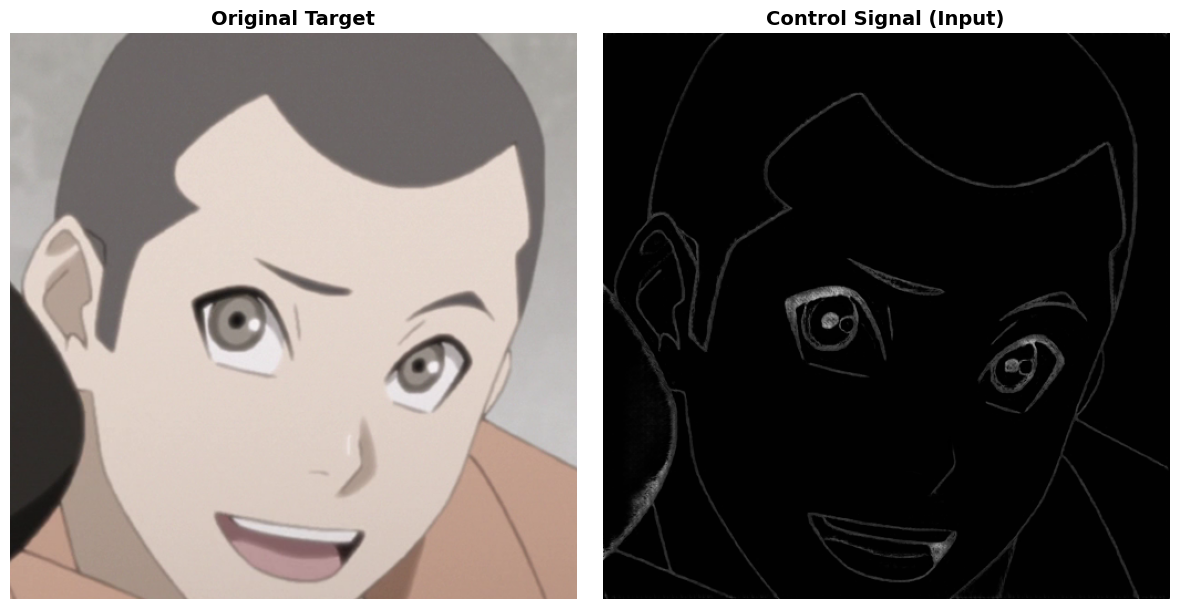

Caption: "a man with a smile on his face"

--------------------------------------------------------------------------------



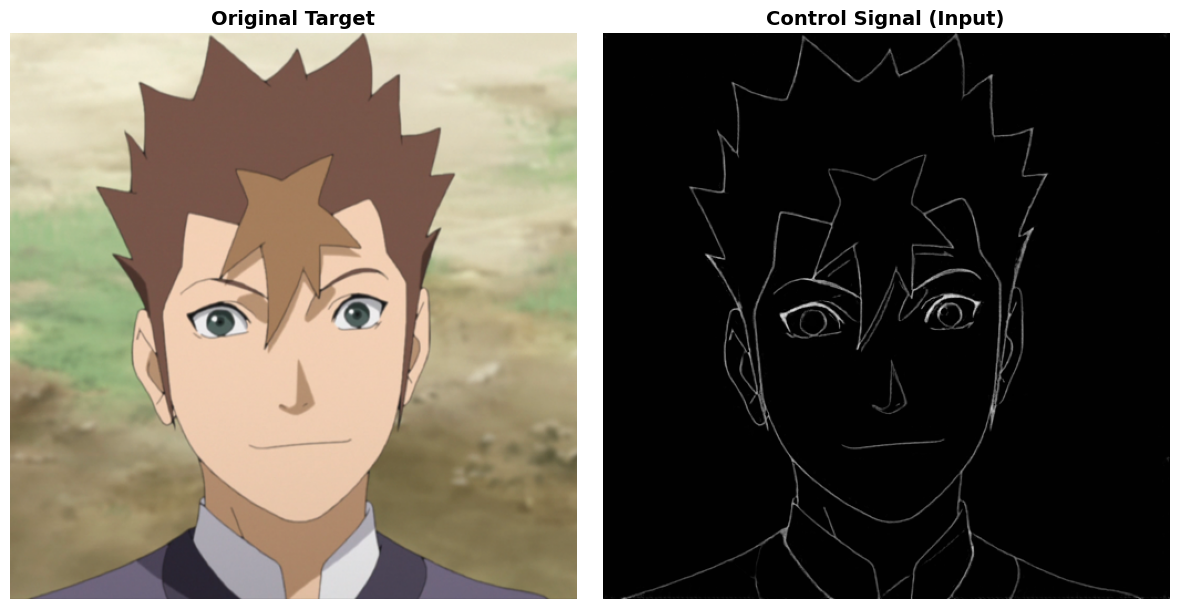

Caption: "a man with brown hair and green eyes"

--------------------------------------------------------------------------------



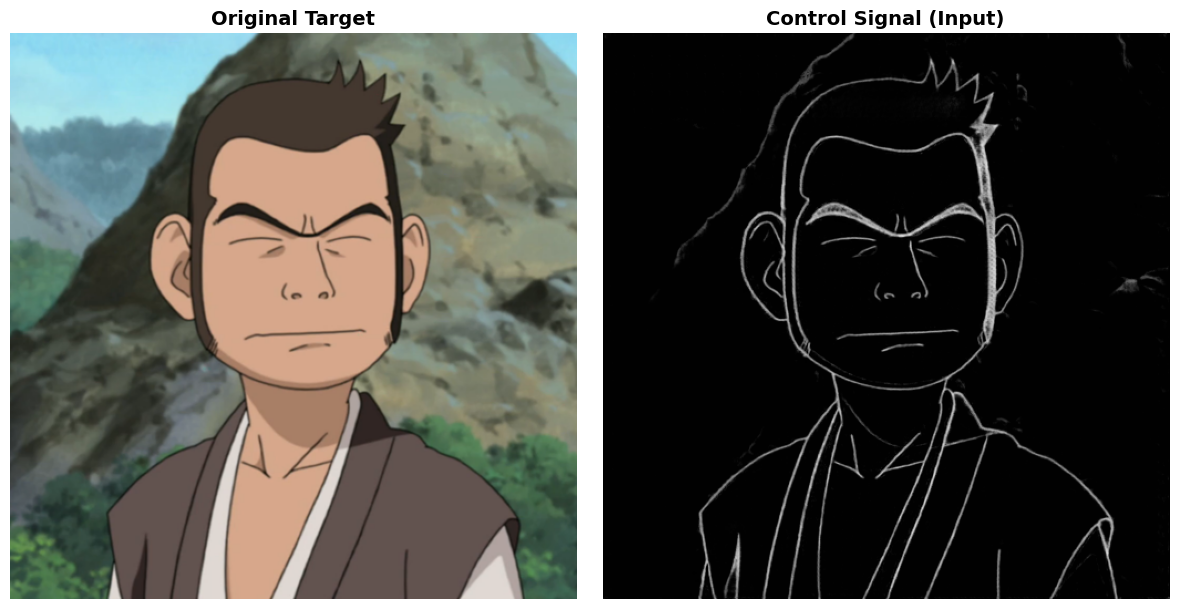

Caption: "a man in a vest and vest standing in front of a mountain"

--------------------------------------------------------------------------------



In [ ]:
view_dataset_samples("/content/Controlnet_Sketch", num_samples=3)